## Mini Project 1 
CE259 - Jessica Camacho, Christopher Tong, Catalina Vanoli 

**Modifying an existing local bus line to Bus Rapid Transit (BRT)**

The Geary transit corridor has one of the highest transit riderships in San Francisco. Current
service on Geary Boulevard has high scheduled frequencies, but is plagued by poor reliability
due to conflicts from operating in mixed traffic, high dwell times at bus stops, excessive signal delays and other difficulties.

In this project we will examine the current situation on Geary Blvd. during the evening rush, as well as the benefits that can be obtained through the introduction of BRT and a hierarchy of service.

**Route Characteristics**

The route consists of a 1.5 mile section in the CBD and 5 miles in the residential area. During a round trip, the bus currently stops at 84 relatively evenly spaced stops along the route including terminals at both ends (thus in each direction there are 41 stops plus the terminal) and the round trip of a bus is 120 min. 50% of this time is spent cruising, 25% loading and unloading(including loss time due to accelerating and decelerating), and 25% of the trip is caused by signal delay. We assume a fixed loss time of 10 sec per stop due to acceleration and deceleration, and that buses do not skip stops. Users take 4 times as long to board as to alight and we will assume that at each stop boarding and alighting movements occur in sequence. Users access bus stops by walking at a speed of 2 mph. Muni has budgeted 40 buses for the route, giving a headway of 3 minutes. 

**Standards for LOS**

We will analyze 3 types of users for this project:
1. Residential to Residential (R→R)
2. CBD to Residential (C→R)
3. Residential to CBD (R→C)

**Data**

The boarding and alighting demand density (PM rush) per hour per mile for service in both
directions is shown in the Mini Project description

In [14]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
import math

%matplotlib inline

L_c = 2*1.5
L_r = 2*5. #residential length

L = (L_c + L_r) #total length of round trip

stops_i = 84.

#in hours
time_roundtrip = 120. / 60

time_cruising = .5
time_load_unload = .25
signal_delay = .25

t_s = 10 / 3600. # time loss per stop
v_s = 2. #walk speed mph

# placeholder
alight_time_frac = 1.
board_time_frac = 4.

N = 40.

# demand

#pax per hr mile
cbd_boarding_to_lobos = 700
residential_boarding_to_lobos = 70
residential_boarding_to_TT = 240

cbd_alighting_to_TT = 600
residential_alighting_to_lobos = 280
residential_alighting_to_TT = 60

In [18]:
#total passengers served by finding total amount of boarding in the system per hour 
#and dividing by amount of buses

pax_board_lobos= L_c/2 * cbd_boarding_to_lobos + L_r * residential_boarding_to_lobos
pax_board_TT = L_r/2 * residential_boarding_to_TT

#pax per bus per hour
pax_board_hour= (pax_board_lobos + pax_board_TT)/ N

pax_alight_lobos= L_r/2 * residential_alighting_to_lobos
pax_alight_TT = L_c/2 * cbd_alighting_to_TT + L_r/2 *residential_alighting_to_TT

pax_alight_hour= (pax_alight_lobos + pax_alight_TT)/ N

print "passengers board per bus: %s" % (pax_board_hour)
print "passengers alight per bus: %s" % (pax_alight_hour)

passengers board per bus: 73.75
passengers alight per bus: 65.0


## Part 1

**Commercial speed:**

In [19]:
# commercial speed (mph)
commercial_speed = L / time_roundtrip

#cruising speed
cruising_speed = L/(time_roundtrip*time_cruising)

print "commercial speed: %s mph" % (commercial_speed)
print "cruising speed: %s mph" % (cruising_speed)

commercial speed: 6.5 mph
cruising speed: 13.0 mph


**Boarding and Alighting time:** 

In [20]:
# bus stops 84 times
total_acc_dec_losstime = stops_i* t_s

# loading and alighting time
alight_time_per_passenger =(time_load_unload * time_roundtrip - total_acc_dec_losstime)/((pax_board_hour* board_time_frac + pax_alight_hour* alight_time_frac)*time_roundtrip)
board_time_per_passenger = alight_time_per_passenger * board_time_frac

print "passenger alight time: %s seconds (tau_a)" % (alight_time_per_passenger*3600)
print "passenger board time: %s seconds (tau_b)" % (board_time_per_passenger*3600)

passenger alight time: 1.33333333333 seconds (tau_a)
passenger board time: 5.33333333333 seconds (tau_b)


henceforth,

$$ 
\tau_a = 1.5 sec
\\
\tau_b = 6 sec
$$

But what is the **optimal stop spacing?** Since initial stop spacing is given and we know the relationship between cruising speed and v_max is: $$ v_c(s) =\frac{s}{t_s + \frac{s}{v_m}}$$

we know **max velocity** given we know the **initial stop spacing** is $ \frac{l} {stops_i}$ and $stops_i = 84 $

In [21]:
s = L / (stops_i)
print "current stop spacing: %s" %(s)
v_max = s/((s/cruising_speed)-t_s)
print "current max velocity: %s mph" %(v_max)

current stop spacing: 0.154761904762
current max velocity: 16.9565217391 mph


### $Riders_{R \rightarrow R}$

the **door to door** travel time is the **sum** of time related to:
* cruising
* acceleration & deceleration loss time
* signal delay
* boarding and alighting of passengers ($\tau$)
* walking 
* waiting

The equation of door to door travel time of an average passenger as a function of length of travel ($l$) and stop spacing ($s$), considering only the ters that affect s:
$$
T(l,s) = \frac{l}{v_cs} + \frac{s}{2v_s} + \frac{10}{3600}\frac{l}{s}
$$

For users who are travelling $R \rightarrow R$ (without going to CBD),

we can estimate the average length of travel distance is: 


$$ 
l_r = \frac{5}{3}
$$

By numerically solving for the root:

stop spacing for Residential stops: [ 0.19214358]


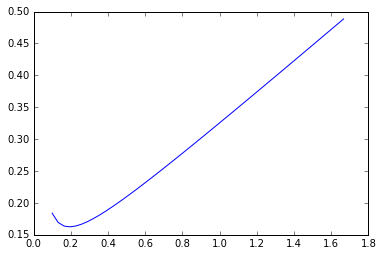

In [177]:
l_r= L_r/(2*3)

def v_c(s):
    return s/(t_s+s/v_max)

# this is not actual T, but only parts that affected stop spacing and trip length (T')
def T(s,l):
    return s/(2*v_s) + l/v_c(s) + t_s*l/s


solution = root(T,.01, l_r) # the second number here 
print "stop spacing for Residential stops: %s" % (solution.x)

s_RtoR = solution.x
plt.plot(np.linspace(.1,l_r),T(np.linspace(.1,l_r),l_r))
plt.show()

Alternatively we can solve in a **closed loop** equation. Given **EOQ** equation is: 

$$
z = Ax^\alpha + Bx^{-\beta}
$$

we can solve for s*:

$$
s^* = \frac{Bm}{An}^{\frac{1}{n+m}} = \sqrt{4t_sv_s[\bar l + \frac{13}{2(40)}]} $$

and so, $s_{r\rightarrow c}^*$ is:

In [125]:
s_RtoR = math.sqrt(4 * t_s * v_s * (l_r + 13/80))

print "optimal stop spacing for residential riders: %s" %s_RtoR

optimal stop spacing for residential riders: 0.19245008973


### $Riders_{C \rightarrow R}$

Riders from CBD to Residential area have different avg travel length. By tracking the amount of boardings and alightings during one trip **westbound** from CBD to the ocean, we can graph an **input output diagram**. 

** See Desmos graph:
https://www.desmos.com/calculator/k3nniwwqj0
**

When calculating the area of the polygon and dividing by the amount of westbound boardings, 

$$Q_b = 700(1.5) + 70(5) = 1400 $$

$$\bar l_c = \frac{3412.5}{Q_b} = 2.44$$ 


We can solve $\bar l_c$ using weighted averages:

$$ 
l_c = \frac{l_a - .25l_r}{.75}$$

$$
l_c = 2.69$$

Using $l_c$ we plug into the EOQ equation to find stop spacing for $C \rightarrow R$ :

In [38]:
l_c = 2.69
s_CtoR = math.sqrt(4 * t_s * v_s * (l_c + 13/80))

print "optimal stop spacing for CBD riders: %s" %s_CtoR

optimal stop spacing for CBD riders: 0.244494944279


The percentage of $C \rightarrow R$ riders is:

In [123]:
Amount_CtoR = L_c/2  * cbd_boarding_to_lobos
Amount_RtoR1 = L_r/2 * (residential_boarding_to_lobos)
Amount_RtoR2= L_r/2 * residential_alighting_to_TT
Amount_RtoC = L_c/2 * cbd_alighting_to_TT

CBD_ratio = (Amount_CtoR+Amount_RtoC)/(Amount_RtoR1 + Amount_RtoR2 + Amount_CtoR+ Amount_RtoC)

print "Ratio of C->R transit: %s" % (CBD_ratio)

Ratio of C->R transit: 0.75


**Reconciling the stop spacings**

By weighting ratio of $C \rightarrow R$ users to $R \rightarrow R$ users, we can find a combined stop spacing as below:

$s^* = .75s_{C \rightarrow R} + .25s_{R\rightarrow R}$

In [132]:
s_star= round(CBD_ratio * s_CtoR + (1- CBD_ratio) * s_RtoR,3)

print "Optimal stop spacing is %s" % (s_star)

Optimal stop spacing is 0.231


So this means in the CBD zone, the optimal stop spacing is:

$s^*_{C} = .25 miles$

Resulting in **6 stops** in the CBD.

The optimal stop spacing in Residential zone is:

$s^*_{R} = .231 miles$

But when rounding the number of stops to obtain an integer number, it results in **21 stops** with a spacing of **.238 miles** between stops.

The optimal spacing may differ from actual spacing for a variety of reasons. One potential reason can be the political pressures to keep or develop a stop at specific landmarks or key places. Stops may be placed closer than optimal as an acknowledgement of the walking penalty. Physical constraints such as block sizing may also affect location. 



## Part 2

**Cruising time**

Travel time as a result of cruising should decrease by 50% while travel time as a result of signal delay should decrease by 50%. Therefore, the breakdown of cycle time from part 1 is invalid. However, as we consider the time loading and unloading to be the same as before (due to the assumption that demand is consistent), we can calculate a new cycle time

In [22]:
signal_delay_time_BRT = signal_delay*.5*time_roundtrip
cruising_time_BRT= time_cruising*time_roundtrip/1.5

cruising_speed_BRT = cruising_speed * 1.5

cycle_time = (signal_delay_time_BRT + cruising_time_BRT + time_roundtrip*time_load_unload)*60

print "%s min" % round(cycle_time)

85.0 min


We can calculate a new $v_{max}$ due to BRT implementation

In [26]:
s= L / (stops_i)
v_max = s/((s/cruising_speed_BRT)-t_s)

print "%s mph" % v_max

30.0 mph


Assuming that the loss time due to acceleration and deceleration $t_s$ remains constant, the only variable affecting length would be distance travelled, which is not a function of cycle time. Therefore, our stop spacing and amount of stops remain unchanged

CBD zone:

$s^*_{C} = .25 miles$

stops : **6 stops**

Residential zone:

$s^*_{R} = .238 miles$

stops: **21 stops** 

The stop spacings for each zone are the same as in part 1 since the optimal spacing EOQ depends on the walking speed, the loss time due to acceleration and deceleration and the average trip length for each type of passenger. 

However, the advantage of implementing a BRT will be reflected in the door to door travel time and the total cycle time which will be reduced due to the terms that in $T$ that include the cruising speed (as v_max increased with the BRT service) and the signal delay ( decreased due to TSP).

Total cycle time approximately when optimizing: **65 minutes** 

Comparing cycle times between BRT and regular service, with the implementation of BRT, the cycle time will be reduced by approximately **38 minutes**. 


## Part 3

In a heirarchy system, $C\rightarrow R$ users will board an express bus and transfer to a local bus at the express stop closest to their destination, $R \rightarrow C$ users will board a local bus and transfer to an express bus at the express stop closest to their origin. We assume all residential users will board the local bus (perhaps due to differences in pricing). 

Whereas in Part 1, we can assume all 40 buses operate the same route, in part 3, a certain percentage of buses operate as express buses while a certain percentage operate as local buses:

$$ 40 = N_l + N_r $$

#### Local Service Considerations

Bus stops for the local service are optimized for residential users. We can therefore optimize the **EOQ** with respect to the share of buses that are servicing the local route (out of 40 buses to serve both local and express):

$$s_L^*(N_l) = \sqrt{4t_sv_s(\bar l_r + \frac{10}{2N_l})}$$

#### Express Considerations

Express service will be given in the following equation:

$$ T_e(S_e,l) = walk_e + wait_e + cruise_e + accel_e + signal_e + wait_L + cruise_L$$

The included functions are below:

For $C \rightarrow R$ passengers: the one way walk time from CBD origin to the express stop. 
For $R \rightarrow C$ passengers: the one way walk time from the express stop to the CBD destination.

- $$ walk_E = \frac{S_E}{4v_s}$$

The wait time at the express stop:

- $$ wait_E = \frac{h_E}{2} = \frac{TT_E}{2N_E} = \frac{1}{2N_E}\Bigg[\frac{13(t_s + \frac{S_E}{V_{max}})}{S_E} + \frac{13t_s}{S_E} + \frac{30(13)}{13} + IVT_E(4\tau_aQ_{bE} + \tau_aQ_{aE})\Bigg]
$$

The cruise time while on express bus with cruise speed as a function of $S_E$, $t_s$ and $v_{max}$:

- $$cruise_E = \frac{\bar l_E(t_s + \frac{S_E}{V_{max}})}{S_E}$$

The acceleration and deceleration time of the express bus (10 seconds per stop):

- $$ accel_E = \frac{\bar l_Et_s}{S_E}$$

The signal delay of express bus: 

- $$ signal_E = \frac{30}{13}(\bar l_E) $$

Waiting for local bus transfer, which is half of the local service headway. At the same time the headway is round trip time divded by the number of local buses:

- $$ wait_L = \frac{h_L}{2}= \frac{TT_L(S_L^*)}{2(40-N_E)}$$

The last portion of the trip, which includes the cruise time of the local service and the walking time after alighting, calculated as an average length between express stops ($\frac{S_E}{4}$) divided by the average speed of the local service:

- $$ cruise_L =  \frac{S_E}{4V(\frac{S_E}{4})} = TT_L(\frac{S_E}{4}) $$

Boarding and alighting time (of the express bus):

- $$board_A = IVT_E\Big[4\tau_aQ_{bE} + \tau_aQ_{aE}\Big]\frac{\bar l_E}{L}$$

given $TT_L$ is:

$$TT_L(\frac{S_E}{4}) = \frac{\frac{S_E}{4}(t_s + \frac{S_L^*}{V_{max}})}{S_L^*} + \frac{\frac{S_E}{4}t_s}{S_E}+ \frac{30}{13}\frac{S_E}{4} + IVT_L\Big(4\tau_aQ_{bL} + \tau_aQ_{aL}\Big)
$$



#### Calculating Demand

The following are the boarding and alighting amounts for express and local bus (pax):

$$
Q_{bE} = \frac{100 x 1.5 + 600 x 1.5}{N_E}
$$

$$
Q_{aE} = \frac{(280-70)s + (240-60)s}{N_E}
$$

$$
Q_{bL} = \frac{70(s) +240(s)}{N_L}
$$

$$
Q_{aL} = \frac{280(s) +60(s)}{N_L}
$$

IVT are the corresponding invehicle times in express bus and in local bus. This includes the cruising time, signal delay, and boarding and alighting. 

### Solution


To calculate the optimal spacing and headway for the hierarchical system, we used the door-to-door travel time equation presented above. For a given number of buses designated as express, we found the optimal value of spacing for the express service that would minimize average door-to-door travel time. We performed iterations changing the percentage of buses designated as express from 10% to 90% and found the optimal express spacing for each case. 

This process was done using the optimal spacing for local services. Given that the ratio between express spacing and local spacing must be an integer (people don’t walk in transfers), we then constrained the spacing for local service to a value close to the optimal that would meet this restriction (SE=2*SL). 

As shown in below tables, the optimal spacing for the express bus is **.38 miles (17 stops), with 22 express buses**. The corresponding optimal headway is 4.7 minutes.  

For local service, the optimal spacing is **.19 miles, with 18 buses. The corresponding optimal headway is 5 minutes.**

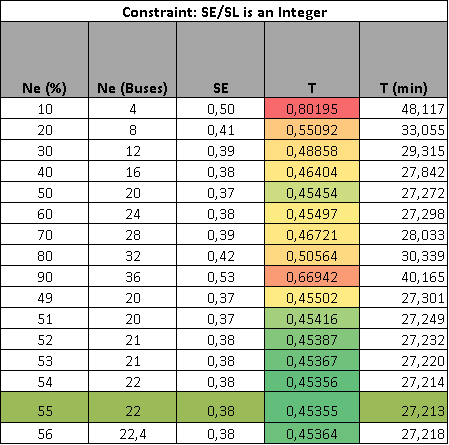

In [11]:
from IPython.display import Image
Image(filename= "table1.png")
#ITERATION TABLE TO FIND OPTIMAL EXPRESS SPACING WITH THE CONSTRAINT

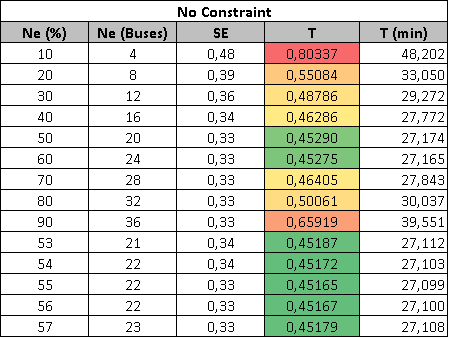

In [12]:
Image(filename= "table2.png")
#ITERATION TABLE TO FIND OPTIMAL EXPRESS SPACING

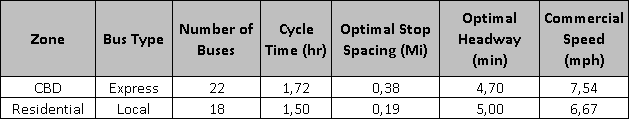

In [13]:
Image(filename= "table3.png")
# SERVICES VALUES

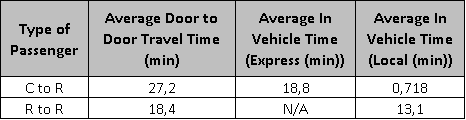

In [14]:
Image(filename= "table4.png")
#PASSENGERS VALUES

# SUMMARY
#### The following tables show the different values obtained when implementing the three studied services: Regular services, BRT System and Hierarchical System

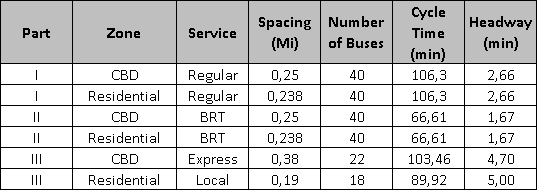

In [15]:
Image(filename= "Summary_Services.png")
#SUMMARY SERVICES' PERFORMANCES VALUES

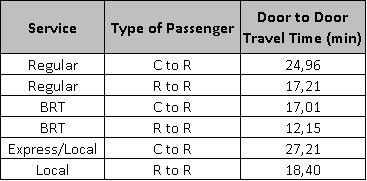

In [16]:
Image(filename= "Summary_Passengers.png")
#SUMMARY DOOR TO DOOR TRAVEL TIME FOR EACH TYPE OF PASSENGER WITH EACH SERVICE. 

## Conclusions

Within the different studied services, the Bus Rapid Transit has the shortest cycle time and door to door travel time per passenger. Although the Hierarchical system reduces the cycle time when compared to the regular system (part I), it results in larger door-to-door travel time for all types of passengers. This is due to the transfer time added when introducing the hierarchy, which for this particular application is not offset by in vehicle travel time savings. For applications with larger route lengths, the hierarchy might start to introduce door to door travel time benefits compared to a regular service.  

See accompanying excel document for optimization solver.